# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

### load data

In [2]:
x_train = np.load('damped_pendulum_data_train.npy')
x_val = np.load('damped_pendulum_data_valid.npy')
x_test = np.load('damped_pendulum_data_test.npy')

kappas_tr, betas_tr = np.loadtxt('damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va = np.loadtxt('damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te = np.loadtxt('damped_pendulum_data_params_test.dat', unpack=True)

rtimes_tr = np.load('rtimes_tr.npy')
rtimes_va = np.load('rtimes_va.npy')
rtimes_te = np.load('rtimes_te.npy')

answers_tr = np.load('answers_tr.npy')
answers_va = np.load('answers_va.npy')
answers_te = np.load('answers_te.npy')

In [3]:
rtimes_tr = rtimes_tr.T
rtimes_va = rtimes_va.T
rtimes_te = rtimes_te.T

answers_tr = answers_tr.T
answers_va = answers_va.T
answers_te = answers_te.T

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Neural Network

In [66]:
num_hidden_layers = 2
encoding_dim = 3
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 512
epochs = 1000
learning_rate = 0.001
regul=0.000013
regul2=0.0002

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [67]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_total_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [68]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_total_loss',
    mode='min',
    verbose=verbose
    )

In [69]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='val_total_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [70]:
encoder_input = keras.Input(shape=(input_dim,))
rtimes_input = keras.Input(shape=(1,))

#encoder 
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_var = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = Sampling()([z_mean, z_log_var])

decoder_input = keras.Input(shape=(encoding_dim+1,)) #1 -> question

#decoder
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers-1):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(1, activation='linear')(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_input, decoded, name='decoder')

# autoencoder = keras.Model([encoder_input, rtimes_input], decoder(tf.concat(values=[encoder(encoder_input)[2], rtimes_input], axis=1)))

In [71]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='recon_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            [x_train, rtimes_tr], answers_tr = data
            z_mean, z_log_var, z = self.encoder(x_train)
            dec_inp = tf.concat(values=[z, rtimes_tr], axis=1)
            reconstruction = self.decoder(dec_inp)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(answers_tr, reconstruction),
                    axis=(-1))) # , 2
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = recon_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(recon_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "recon_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
        
    def test_step(self, data):
        [x_test, rtimes_te], answers_te = data
        z_mean, z_log_var, z = self.encoder(x_test)
        dec_inp = tf.concat(values=[z, rtimes_te], axis=1)
        reconstruction = self.decoder(dec_inp)
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(answers_te, reconstruction),
                axis=(-1))) # , 2
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = recon_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "recon_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [72]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), run_eagerly=True)

## training the model

In [73]:
fitting_output = vae.fit([x_train, rtimes_tr], answers_tr,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=([x_val, rtimes_va], answers_va),
                          callbacks=[reduce_lr, early_stopping_callback])

Epoch 1/1000
28/28 [==============================] - 2s 76ms/step - total_loss: 82.5621 - recon_loss: 82.0565 - kl_loss: 0.5057 - val_total_loss: 44.1284 - val_recon_loss: 43.6914 - val_kl_loss: 0.4370 - lr: 0.0010
Epoch 2/1000
28/28 [==============================] - 2s 81ms/step - total_loss: 41.3610 - recon_loss: 40.7266 - kl_loss: 0.6343 - val_total_loss: 37.1887 - val_recon_loss: 36.3419 - val_kl_loss: 0.8468 - lr: 0.0010
Epoch 3/1000
28/28 [==============================] - 3s 105ms/step - total_loss: 37.9502 - recon_loss: 36.8477 - kl_loss: 1.1025 - val_total_loss: 35.5717 - val_recon_loss: 34.3004 - val_kl_loss: 1.2713 - lr: 0.0010
Epoch 4/1000
28/28 [==============================] - 2s 82ms/step - total_loss: 36.2753 - recon_loss: 34.5706 - kl_loss: 1.7048 - val_total_loss: 34.6364 - val_recon_loss: 32.7474 - val_kl_loss: 1.8890 - lr: 0.0010
Epoch 5/1000
28/28 [==============================] - 2s 80ms/step - total_loss: 34.9887 - recon_loss: 32.9394 - kl_loss: 2.0494 - val_

Epoch 39/1000
28/28 [==============================] - 4s 136ms/step - total_loss: 22.7005 - recon_loss: 19.8685 - kl_loss: 2.8319 - val_total_loss: 21.2180 - val_recon_loss: 18.5105 - val_kl_loss: 2.7075 - lr: 0.0010
Epoch 40/1000
28/28 [==============================] - 3s 115ms/step - total_loss: 22.7101 - recon_loss: 19.8522 - kl_loss: 2.8580 - val_total_loss: 22.0779 - val_recon_loss: 19.2231 - val_kl_loss: 2.8548 - lr: 0.0010
Epoch 41/1000
28/28 [==============================] - 3s 111ms/step - total_loss: 22.9560 - recon_loss: 20.1083 - kl_loss: 2.8477 - val_total_loss: 21.7717 - val_recon_loss: 18.9764 - val_kl_loss: 2.7953 - lr: 0.0010
Epoch 42/1000
28/28 [==============================] - 3s 111ms/step - total_loss: 22.6999 - recon_loss: 19.7451 - kl_loss: 2.9547 - val_total_loss: 20.2866 - val_recon_loss: 17.4408 - val_kl_loss: 2.8458 - lr: 0.0010
Epoch 43/1000
28/28 [==============================] - 3s 110ms/step - total_loss: 22.2277 - recon_loss: 19.3949 - kl_loss: 2.83

Epoch 77/1000
28/28 [==============================] - 4s 125ms/step - total_loss: 18.8867 - recon_loss: 15.6385 - kl_loss: 3.2481 - val_total_loss: 18.0910 - val_recon_loss: 14.9445 - val_kl_loss: 3.1465 - lr: 0.0010
Epoch 78/1000
28/28 [==============================] - 3s 95ms/step - total_loss: 19.4253 - recon_loss: 16.2850 - kl_loss: 3.1402 - val_total_loss: 17.6387 - val_recon_loss: 14.4069 - val_kl_loss: 3.2318 - lr: 0.0010
Epoch 79/1000
28/28 [==============================] - 3s 95ms/step - total_loss: 18.8885 - recon_loss: 15.7270 - kl_loss: 3.1615 - val_total_loss: 17.1836 - val_recon_loss: 13.9437 - val_kl_loss: 3.2399 - lr: 0.0010
Epoch 80/1000
28/28 [==============================] - 3s 103ms/step - total_loss: 18.4952 - recon_loss: 15.2707 - kl_loss: 3.2245 - val_total_loss: 17.6739 - val_recon_loss: 14.4385 - val_kl_loss: 3.2354 - lr: 0.0010
Epoch 81/1000
28/28 [==============================] - 3s 116ms/step - total_loss: 18.8086 - recon_loss: 15.5889 - kl_loss: 3.2197

28/28 [==============================] - 3s 105ms/step - total_loss: 17.2011 - recon_loss: 13.7670 - kl_loss: 3.4341 - val_total_loss: 15.4679 - val_recon_loss: 12.1966 - val_kl_loss: 3.2713 - lr: 0.0010
Epoch 115/1000
28/28 [==============================] - 3s 105ms/step - total_loss: 16.4370 - recon_loss: 13.0453 - kl_loss: 3.3917 - val_total_loss: 15.6867 - val_recon_loss: 12.4029 - val_kl_loss: 3.2837 - lr: 0.0010
Epoch 116/1000
28/28 [==============================] - 3s 99ms/step - total_loss: 16.5327 - recon_loss: 13.1510 - kl_loss: 3.3817 - val_total_loss: 15.9348 - val_recon_loss: 12.5803 - val_kl_loss: 3.3546 - lr: 0.0010
Epoch 117/1000
28/28 [==============================] - 3s 108ms/step - total_loss: 16.3892 - recon_loss: 12.9682 - kl_loss: 3.4210 - val_total_loss: 15.7584 - val_recon_loss: 12.4383 - val_kl_loss: 3.3201 - lr: 0.0010
Epoch 118/1000
28/28 [==============================] - 3s 102ms/step - total_loss: 16.5263 - recon_loss: 13.1245 - kl_loss: 3.4018 - val_to

28/28 [==============================] - 3s 104ms/step - total_loss: 15.0767 - recon_loss: 11.5599 - kl_loss: 3.5168 - val_total_loss: 14.5948 - val_recon_loss: 11.1281 - val_kl_loss: 3.4668 - lr: 0.0010
Epoch 152/1000
28/28 [==============================] - 3s 112ms/step - total_loss: 15.0629 - recon_loss: 11.5843 - kl_loss: 3.4786 - val_total_loss: 14.5466 - val_recon_loss: 10.9818 - val_kl_loss: 3.5648 - lr: 0.0010
Epoch 153/1000
28/28 [==============================] - 3s 100ms/step - total_loss: 15.0507 - recon_loss: 11.5225 - kl_loss: 3.5282 - val_total_loss: 14.4036 - val_recon_loss: 10.7876 - val_kl_loss: 3.6160 - lr: 0.0010
Epoch 154/1000
28/28 [==============================] - 3s 111ms/step - total_loss: 14.9014 - recon_loss: 11.3972 - kl_loss: 3.5042 - val_total_loss: 15.0463 - val_recon_loss: 11.5351 - val_kl_loss: 3.5112 - lr: 0.0010
Epoch 155/1000
28/28 [==============================] - 3s 112ms/step - total_loss: 15.2104 - recon_loss: 11.7222 - kl_loss: 3.4882 - val_t

28/28 [==============================] - 3s 93ms/step - total_loss: 13.8092 - recon_loss: 10.1925 - kl_loss: 3.6166 - val_total_loss: 14.2040 - val_recon_loss: 10.6239 - val_kl_loss: 3.5801 - lr: 0.0010
Epoch 189/1000
28/28 [==============================] - 3s 93ms/step - total_loss: 13.8725 - recon_loss: 10.2913 - kl_loss: 3.5812 - val_total_loss: 14.5673 - val_recon_loss: 10.9982 - val_kl_loss: 3.5691 - lr: 0.0010
Epoch 190/1000
28/28 [==============================] - 2s 89ms/step - total_loss: 13.7658 - recon_loss: 10.1056 - kl_loss: 3.6602 - val_total_loss: 13.1762 - val_recon_loss: 9.5690 - val_kl_loss: 3.6071 - lr: 0.0010
Epoch 191/1000
28/28 [==============================] - 3s 92ms/step - total_loss: 13.5686 - recon_loss: 9.9497 - kl_loss: 3.6189 - val_total_loss: 13.4834 - val_recon_loss: 9.8502 - val_kl_loss: 3.6332 - lr: 0.0010
Epoch 192/1000
28/28 [==============================] - 2s 86ms/step - total_loss: 13.5499 - recon_loss: 9.9209 - kl_loss: 3.6290 - val_total_loss

Epoch 226/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 12.6373 - recon_loss: 8.9752 - kl_loss: 3.6621 - val_total_loss: 12.7129 - val_recon_loss: 9.0586 - val_kl_loss: 3.6543 - lr: 0.0010
Epoch 227/1000
28/28 [==============================] - 3s 92ms/step - total_loss: 12.4999 - recon_loss: 8.7878 - kl_loss: 3.7121 - val_total_loss: 12.6991 - val_recon_loss: 8.8586 - val_kl_loss: 3.8405 - lr: 0.0010
Epoch 228/1000
28/28 [==============================] - 3s 93ms/step - total_loss: 12.3365 - recon_loss: 8.6305 - kl_loss: 3.7060 - val_total_loss: 12.4867 - val_recon_loss: 8.7171 - val_kl_loss: 3.7696 - lr: 0.0010
Epoch 229/1000
28/28 [==============================] - 3s 93ms/step - total_loss: 12.3874 - recon_loss: 8.6691 - kl_loss: 3.7182 - val_total_loss: 13.4041 - val_recon_loss: 9.7176 - val_kl_loss: 3.6866 - lr: 0.0010
Epoch 230/1000
28/28 [==============================] - 3s 91ms/step - total_loss: 12.5340 - recon_loss: 8.8710 - kl_loss: 3.6630 - val_

Epoch 264/1000
28/28 [==============================] - 2s 82ms/step - total_loss: 11.5844 - recon_loss: 7.8944 - kl_loss: 3.6900 - val_total_loss: 11.5671 - val_recon_loss: 7.9017 - val_kl_loss: 3.6653 - lr: 0.0010
Epoch 265/1000
28/28 [==============================] - 2s 81ms/step - total_loss: 11.5046 - recon_loss: 7.7701 - kl_loss: 3.7345 - val_total_loss: 12.1798 - val_recon_loss: 8.4883 - val_kl_loss: 3.6915 - lr: 0.0010
Epoch 266/1000
28/28 [==============================] - 2s 80ms/step - total_loss: 11.7035 - recon_loss: 8.0073 - kl_loss: 3.6961 - val_total_loss: 11.7176 - val_recon_loss: 8.0019 - val_kl_loss: 3.7157 - lr: 0.0010
Epoch 267/1000
28/28 [==============================] - 2s 79ms/step - total_loss: 11.7943 - recon_loss: 8.1155 - kl_loss: 3.6788 - val_total_loss: 13.2614 - val_recon_loss: 9.3950 - val_kl_loss: 3.8663 - lr: 0.0010
Epoch 268/1000
28/28 [==============================] - 2s 80ms/step - total_loss: 12.1117 - recon_loss: 8.3897 - kl_loss: 3.7221 - val_

Epoch 302/1000
28/28 [==============================] - 3s 91ms/step - total_loss: 11.2380 - recon_loss: 7.5691 - kl_loss: 3.6688 - val_total_loss: 11.1338 - val_recon_loss: 7.3775 - val_kl_loss: 3.7563 - lr: 0.0010
Epoch 303/1000
28/28 [==============================] - 2s 84ms/step - total_loss: 11.0089 - recon_loss: 7.2496 - kl_loss: 3.7593 - val_total_loss: 11.2939 - val_recon_loss: 7.5422 - val_kl_loss: 3.7517 - lr: 0.0010
Epoch 304/1000
28/28 [==============================] - 2s 82ms/step - total_loss: 11.0075 - recon_loss: 7.2404 - kl_loss: 3.7670 - val_total_loss: 11.3247 - val_recon_loss: 7.7311 - val_kl_loss: 3.5937 - lr: 0.0010
Epoch 305/1000
28/28 [==============================] - 3s 90ms/step - total_loss: 11.1093 - recon_loss: 7.4037 - kl_loss: 3.7056 - val_total_loss: 10.7731 - val_recon_loss: 6.9737 - val_kl_loss: 3.7994 - lr: 0.0010
Epoch 306/1000
28/28 [==============================] - 2s 76ms/step - total_loss: 10.9874 - recon_loss: 7.2026 - kl_loss: 3.7848 - val_

Epoch 340/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 10.4614 - recon_loss: 6.7451 - kl_loss: 3.7164 - val_total_loss: 10.8181 - val_recon_loss: 6.9917 - val_kl_loss: 3.8264 - lr: 0.0010
Epoch 341/1000
28/28 [==============================] - 3s 110ms/step - total_loss: 10.4745 - recon_loss: 6.6688 - kl_loss: 3.8057 - val_total_loss: 10.5916 - val_recon_loss: 6.7809 - val_kl_loss: 3.8107 - lr: 0.0010
Epoch 342/1000
28/28 [==============================] - 3s 125ms/step - total_loss: 10.5735 - recon_loss: 6.8191 - kl_loss: 3.7544 - val_total_loss: 11.4027 - val_recon_loss: 7.6734 - val_kl_loss: 3.7293 - lr: 0.0010
Epoch 343/1000
28/28 [==============================] - 4s 129ms/step - total_loss: 10.6384 - recon_loss: 6.8552 - kl_loss: 3.7832 - val_total_loss: 10.3994 - val_recon_loss: 6.6274 - val_kl_loss: 3.7719 - lr: 0.0010
Epoch 344/1000
28/28 [==============================] - 4s 127ms/step - total_loss: 10.5194 - recon_loss: 6.7554 - kl_loss: 3.7641 - 

Epoch 378/1000
28/28 [==============================] - 2s 83ms/step - total_loss: 9.8216 - recon_loss: 6.0337 - kl_loss: 3.7879 - val_total_loss: 9.8229 - val_recon_loss: 5.9977 - val_kl_loss: 3.8252 - lr: 0.0010
Epoch 379/1000
28/28 [==============================] - 2s 85ms/step - total_loss: 10.2776 - recon_loss: 6.4991 - kl_loss: 3.7785 - val_total_loss: 10.3445 - val_recon_loss: 6.6371 - val_kl_loss: 3.7074 - lr: 0.0010
Epoch 380/1000
28/28 [==============================] - 2s 83ms/step - total_loss: 9.6702 - recon_loss: 5.8320 - kl_loss: 3.8382 - val_total_loss: 10.1290 - val_recon_loss: 6.5068 - val_kl_loss: 3.6221 - lr: 0.0010
Epoch 381/1000
28/28 [==============================] - 2s 83ms/step - total_loss: 10.1008 - recon_loss: 6.3699 - kl_loss: 3.7309 - val_total_loss: 12.2583 - val_recon_loss: 8.3967 - val_kl_loss: 3.8616 - lr: 0.0010
Epoch 382/1000
28/28 [==============================] - 2s 83ms/step - total_loss: 10.3206 - recon_loss: 6.4513 - kl_loss: 3.8694 - val_tot

28/28 [==============================] - 2s 83ms/step - total_loss: 9.5710 - recon_loss: 5.7994 - kl_loss: 3.7716 - val_total_loss: 10.5585 - val_recon_loss: 6.7634 - val_kl_loss: 3.7952 - lr: 0.0010
Epoch 417/1000
28/28 [==============================] - 2s 79ms/step - total_loss: 9.5535 - recon_loss: 5.7910 - kl_loss: 3.7625 - val_total_loss: 9.5940 - val_recon_loss: 5.6340 - val_kl_loss: 3.9600 - lr: 0.0010
Epoch 418/1000
28/28 [==============================] - 2s 79ms/step - total_loss: 9.3776 - recon_loss: 5.5484 - kl_loss: 3.8292 - val_total_loss: 9.8305 - val_recon_loss: 5.9727 - val_kl_loss: 3.8578 - lr: 0.0010
Epoch 419/1000
28/28 [==============================] - 2s 80ms/step - total_loss: 9.5733 - recon_loss: 5.7406 - kl_loss: 3.8327 - val_total_loss: 10.1658 - val_recon_loss: 6.3693 - val_kl_loss: 3.7965 - lr: 0.0010
Epoch 420/1000
28/28 [==============================] - 2s 80ms/step - total_loss: 9.6083 - recon_loss: 5.7526 - kl_loss: 3.8558 - val_total_loss: 9.6503 - v

28/28 [==============================] - 3s 111ms/step - total_loss: 9.0587 - recon_loss: 5.1876 - kl_loss: 3.8712 - val_total_loss: 9.2875 - val_recon_loss: 5.4003 - val_kl_loss: 3.8871 - lr: 0.0010
Epoch 455/1000
28/28 [==============================] - 3s 112ms/step - total_loss: 8.9586 - recon_loss: 5.1481 - kl_loss: 3.8105 - val_total_loss: 9.6390 - val_recon_loss: 5.7578 - val_kl_loss: 3.8812 - lr: 0.0010
Epoch 456/1000
28/28 [==============================] - 4s 127ms/step - total_loss: 8.9798 - recon_loss: 5.1088 - kl_loss: 3.8710 - val_total_loss: 9.0365 - val_recon_loss: 5.2128 - val_kl_loss: 3.8237 - lr: 0.0010
Epoch 457/1000
28/28 [==============================] - 3s 117ms/step - total_loss: 9.0106 - recon_loss: 5.1971 - kl_loss: 3.8135 - val_total_loss: 9.4557 - val_recon_loss: 5.5981 - val_kl_loss: 3.8576 - lr: 0.0010
Epoch 458/1000
28/28 [==============================] - 3s 105ms/step - total_loss: 9.0576 - recon_loss: 5.2381 - kl_loss: 3.8195 - val_total_loss: 9.2749 

28/28 [==============================] - 4s 155ms/step - total_loss: 8.7896 - recon_loss: 4.9724 - kl_loss: 3.8172 - val_total_loss: 9.2728 - val_recon_loss: 5.3811 - val_kl_loss: 3.8917 - lr: 0.0010
Epoch 493/1000
28/28 [==============================] - 4s 146ms/step - total_loss: 8.9613 - recon_loss: 5.0895 - kl_loss: 3.8717 - val_total_loss: 9.4987 - val_recon_loss: 5.5847 - val_kl_loss: 3.9140 - lr: 0.0010
Epoch 494/1000
28/28 [==============================] - 4s 135ms/step - total_loss: 9.0711 - recon_loss: 5.3014 - kl_loss: 3.7697 - val_total_loss: 9.6377 - val_recon_loss: 5.7578 - val_kl_loss: 3.8799 - lr: 0.0010
Epoch 495/1000
28/28 [==============================] - 5s 167ms/step - total_loss: 9.2830 - recon_loss: 5.4176 - kl_loss: 3.8654 - val_total_loss: 10.9659 - val_recon_loss: 7.1310 - val_kl_loss: 3.8349 - lr: 0.0010
Epoch 496/1000
28/28 [==============================] - 4s 130ms/step - total_loss: 9.4427 - recon_loss: 5.6592 - kl_loss: 3.7835 - val_total_loss: 10.673

28/28 [==============================] - 3s 119ms/step - total_loss: 8.6174 - recon_loss: 4.7758 - kl_loss: 3.8416 - val_total_loss: 9.0603 - val_recon_loss: 5.1032 - val_kl_loss: 3.9571 - lr: 0.0010
Epoch 531/1000
28/28 [==============================] - 3s 105ms/step - total_loss: 8.6071 - recon_loss: 4.7536 - kl_loss: 3.8535 - val_total_loss: 9.3743 - val_recon_loss: 5.5172 - val_kl_loss: 3.8571 - lr: 0.0010
Epoch 532/1000
28/28 [==============================] - 3s 105ms/step - total_loss: 8.6782 - recon_loss: 4.8395 - kl_loss: 3.8387 - val_total_loss: 9.4357 - val_recon_loss: 5.5410 - val_kl_loss: 3.8948 - lr: 0.0010
Epoch 533/1000
28/28 [==============================] - 3s 101ms/step - total_loss: 8.5554 - recon_loss: 4.7584 - kl_loss: 3.7971 - val_total_loss: 8.8442 - val_recon_loss: 4.9846 - val_kl_loss: 3.8596 - lr: 0.0010
Epoch 534/1000
28/28 [==============================] - 3s 102ms/step - total_loss: 8.7365 - recon_loss: 4.8829 - kl_loss: 3.8536 - val_total_loss: 8.8809 

28/28 [==============================] - 4s 127ms/step - total_loss: 8.4873 - recon_loss: 4.6473 - kl_loss: 3.8400 - val_total_loss: 9.9655 - val_recon_loss: 6.1996 - val_kl_loss: 3.7658 - lr: 0.0010
Epoch 569/1000
28/28 [==============================] - 4s 134ms/step - total_loss: 8.8796 - recon_loss: 5.0457 - kl_loss: 3.8339 - val_total_loss: 9.8374 - val_recon_loss: 5.9498 - val_kl_loss: 3.8876 - lr: 0.0010
Epoch 570/1000
28/28 [==============================] - 3s 121ms/step - total_loss: 9.0431 - recon_loss: 5.2352 - kl_loss: 3.8078 - val_total_loss: 10.6612 - val_recon_loss: 6.8040 - val_kl_loss: 3.8572 - lr: 0.0010
Epoch 571/1000
28/28 [==============================] - 4s 161ms/step - total_loss: 8.9189 - recon_loss: 5.0513 - kl_loss: 3.8676 - val_total_loss: 8.6818 - val_recon_loss: 4.8403 - val_kl_loss: 3.8414 - lr: 0.0010
Epoch 572/1000
28/28 [==============================] - 4s 133ms/step - total_loss: 8.3889 - recon_loss: 4.5579 - kl_loss: 3.8310 - val_total_loss: 8.8801

28/28 [==============================] - 3s 116ms/step - total_loss: 8.4295 - recon_loss: 4.5619 - kl_loss: 3.8676 - val_total_loss: 9.0375 - val_recon_loss: 5.2113 - val_kl_loss: 3.8262 - lr: 0.0010
Epoch 607/1000
28/28 [==============================] - 4s 138ms/step - total_loss: 8.6667 - recon_loss: 4.8366 - kl_loss: 3.8301 - val_total_loss: 9.3004 - val_recon_loss: 5.4993 - val_kl_loss: 3.8011 - lr: 0.0010
Epoch 608/1000
28/28 [==============================] - 3s 109ms/step - total_loss: 9.1636 - recon_loss: 5.3764 - kl_loss: 3.7872 - val_total_loss: 9.0662 - val_recon_loss: 5.2876 - val_kl_loss: 3.7786 - lr: 0.0010
Epoch 609/1000
28/28 [==============================] - 3s 111ms/step - total_loss: 8.4891 - recon_loss: 4.6277 - kl_loss: 3.8614 - val_total_loss: 8.8382 - val_recon_loss: 5.0402 - val_kl_loss: 3.7980 - lr: 0.0010
Epoch 610/1000
28/28 [==============================] - 3s 100ms/step - total_loss: 8.5005 - recon_loss: 4.7161 - kl_loss: 3.7844 - val_total_loss: 8.8760 

28/28 [==============================] - 4s 127ms/step - total_loss: 9.0044 - recon_loss: 5.1722 - kl_loss: 3.8321 - val_total_loss: 9.5129 - val_recon_loss: 5.6380 - val_kl_loss: 3.8749 - lr: 0.0010
Epoch 645/1000
28/28 [==============================] - 4s 127ms/step - total_loss: 8.5758 - recon_loss: 4.7483 - kl_loss: 3.8275 - val_total_loss: 8.7482 - val_recon_loss: 4.8190 - val_kl_loss: 3.9293 - lr: 0.0010
Epoch 646/1000
28/28 [==============================] - 3s 109ms/step - total_loss: 8.3390 - recon_loss: 4.4829 - kl_loss: 3.8561 - val_total_loss: 8.7650 - val_recon_loss: 4.8917 - val_kl_loss: 3.8734 - lr: 0.0010
Epoch 647/1000
28/28 [==============================] - 3s 117ms/step - total_loss: 8.3296 - recon_loss: 4.4508 - kl_loss: 3.8788 - val_total_loss: 8.9349 - val_recon_loss: 5.1303 - val_kl_loss: 3.8046 - lr: 0.0010
Epoch 648/1000
28/28 [==============================] - 4s 130ms/step - total_loss: 8.6413 - recon_loss: 4.8196 - kl_loss: 3.8217 - val_total_loss: 9.4439 

In [74]:
training_history = fitting_output.history

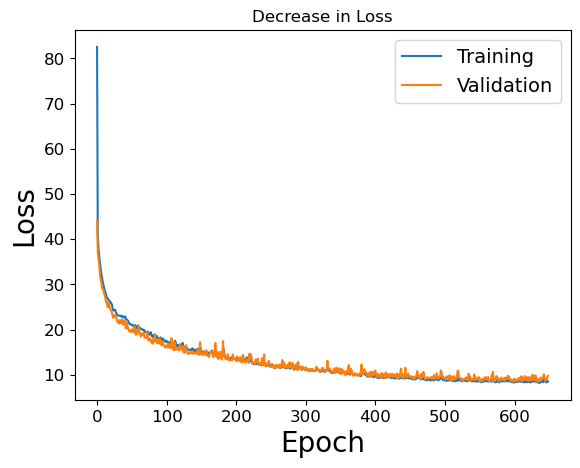

In [75]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['total_loss'], label='Training')
ax.plot(fitting_output.history['val_total_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xticks(np.arange(0, epochs, 1))
# ax.set_ylim(0, 25)
plt.show()

## testing the model

In [76]:
# compare autoencoder model to encoder and decoder models

# f1 = autoencoder.predict([x_test, rtimes_te])
f2 = decoder(np.concatenate((encoder(x_test)[2].numpy(), rtimes_te), axis=1))

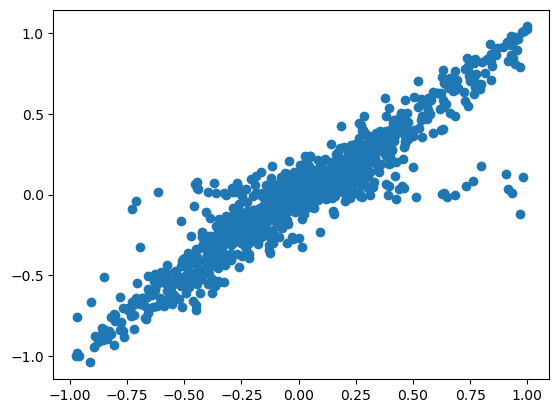

In [77]:
# plt.plot(answers_te, f1, 'o')
plt.plot(answers_te, f2, 'o')

In [78]:
encoded_data = encoder(x_test)[2]

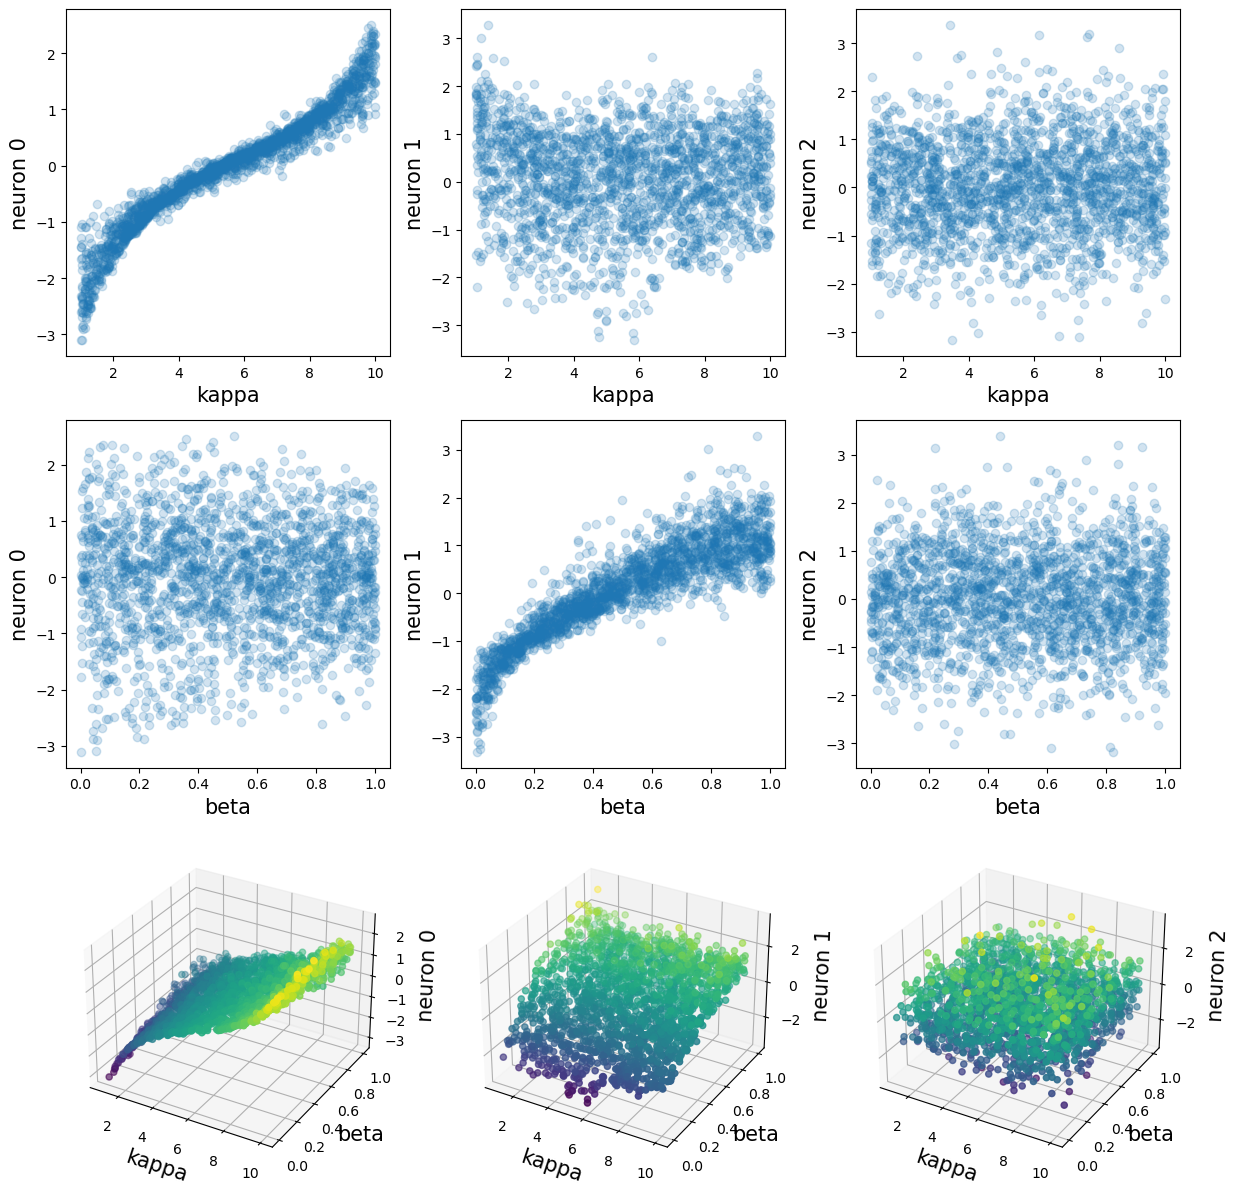

In [79]:
graphs = 'graphs_for_report'
save_path = f"new_batch:{batch_size}_lr:{learning_rate}_regul:{regul}_regul2:{regul2}_VAE_q_cl"

fontsize = 15

fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(331)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_xlabel('kappa', fontsize=fontsize)
ax1.set_ylabel('neuron 0', fontsize=fontsize)

ax2 = fig.add_subplot(334)
ax2.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax2.set_xlabel('beta', fontsize=fontsize)
ax2.set_ylabel('neuron 0', fontsize=fontsize)

ax3 = fig.add_subplot(332)
ax3.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax3.set_xlabel('kappa', fontsize=fontsize)
ax3.set_ylabel('neuron 1', fontsize=fontsize)

ax4 = fig.add_subplot(335)
ax4.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax4.set_xlabel('beta', fontsize=fontsize)
ax4.set_ylabel('neuron 1', fontsize=fontsize)

ax5 = fig.add_subplot(333)
ax5.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax5.set_xlabel('kappa', fontsize=fontsize)
ax5.set_ylabel('neuron 2', fontsize=fontsize)

ax6 = fig.add_subplot(336)
ax6.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax6.set_xlabel('beta', fontsize=fontsize)
ax6.set_ylabel('neuron 2', fontsize=fontsize)

ax7 = fig.add_subplot(337, projection='3d')
ax7.scatter(kappas_te, betas_te, encoded_data[:, 0], c=encoded_data[:, 0])
ax7.set_xlabel('kappa', fontsize=fontsize)
ax7.set_ylabel('beta', fontsize=fontsize)
ax7.set_zlabel('neuron 0', fontsize=fontsize)

ax8 = fig.add_subplot(338, projection='3d')
ax8.scatter(kappas_te, betas_te, encoded_data[:, 1], c=encoded_data[:, 1])
ax8.set_xlabel('kappa', fontsize=fontsize)
ax8.set_ylabel('beta', fontsize=fontsize)
ax8.set_zlabel('neuron 1', fontsize=fontsize)

ax9 = fig.add_subplot(339, projection='3d')
ax9.scatter(kappas_te, betas_te, encoded_data[:, 2], c=encoded_data[:, 2])
ax9.set_xlabel('kappa', fontsize=fontsize)
ax9.set_ylabel('beta', fontsize=fontsize)
ax9.set_zlabel('neuron 2', fontsize=fontsize)

plt.tight_layout()
graphs_file_path = os.path.join(graphs, save_path)
plt.savefig(os.path.join(f"{graphs_file_path}.png"))
plt.show()
plt.close(fig)

(array([ 10.,  48., 157., 347., 515., 478., 308., 107.,  22.,   8.]),
 array([-3.1767697 , -2.5210497 , -1.8653299 , -1.20961   , -0.55389005,
         0.10182989,  0.7575498 ,  1.4132698 ,  2.0689898 ,  2.7247095 ,
         3.3804295 ], dtype=float32),
 <BarContainer object of 10 artists>)

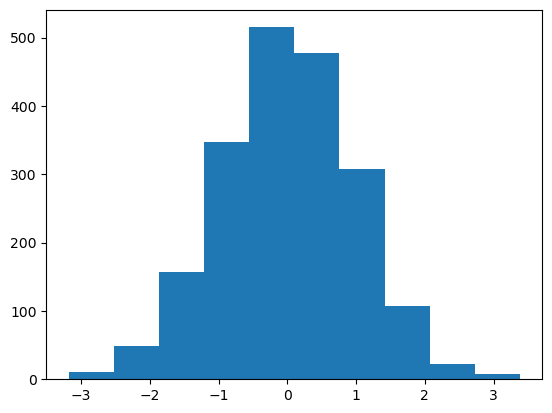

In [80]:
plt.hist(encoded_data[:,2])

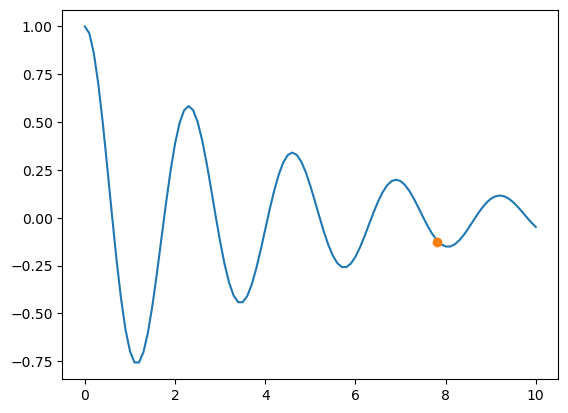

In [82]:
t = np.linspace(0, 10, 101)
plt.plot(t, x_train[9])
plt.plot(rtimes_tr[9], answers_tr[9], 'o')
plt.savefig('predict_answer')